# Representing Object Association with Vector Similarity
Steven Agland - [sagland@gmail.com](mailto:sagland@gmail.com)

# Abstract

In many data applications it is common to track a large number of objects with a large number of connections between them. In such situations in can be useful to detect possible indirect associations between a pair of objects which may be implicit in the common connections from the pair to other objects. Examples of such applications include [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) in [recommender systems](https://en.wikipedia.org/wiki/Recommender_system), [information retrieval](https://en.wikipedia.org/wiki/Information_retrieval), and [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection).

Finding and ranking such indirect associations efficiently is a difficult computation problem. In this notebook I explore the idea of using fixed-length vectors assigned to each object to encode associations probabilistically. The strength of association between a pair of objects is represented by the similarity of their vectors and can be meaningful even if no explicit association were provided in the input data. There need be no meaning inherent in the elements of the vectors themselves, which can be seeded with random values. But an iterative refinement process can adjust the values such that their similarity to one another reflects the association of their corresponding objects. This provides a fast means of computing the likihood of an association between any two objects for which no prior knowledge exists.

I consider the tradeoffs involved in the selection of vector spaces and algorithms for refining the vectors, and develop measures for evaluating their performance. In particular I'll evaluate two related classes of vector spaces: hyperspherical surfaces, and bit strings.

# Introduction

## The Problem

Consider a recommender system to which you can provide a set of your personal preferences. These may related to food, music, hobbies, political persuasions, life values and so on. Given these, and the knowledge of the preferences of thousands of other users, the system might predict your preference in areas for which you've provided no information, or for which you do not yet have a preference. For example, the system might predict which of three countries you would most enjoy visiting, even though you have yet to visit any of them. This prediction would be informed by the input from other users with preferences similar to yours.

How could the system make such a prediction? What if you expressed no preferences in common with any other user who had expressed a preference for the countries in question? Could an indirect association be found without an direct association between those concepts being known? In this example, perhaps a taste for spicy food correlates with tourism tropical countries. Could that association be determined automatically as a probability-like score?

This simple preference prediction system serves as an example application to which I will refer throughout the rest of this notebook. It should be clear how such an approach could be applied to other systems, such as product recommender engines in online stores, automated news feeds, targeted advertising, detecting correlations in complex data sets, and so on.

The process described here is one way to solve this problem, and many other solutions already exist. It may well be that the concepts explored herein have been thoroughly mapped elsewhere in terms with which I'm unfamiliar, and in research I haven't been able to find. Pointers to existing papers are welcome, and I hope that the ideas presented here could be of value to readers and researchers interested in such topics.

## Approach

I explore the idea of mapping each object to a vector in such a way that vector similarity implies object association. The hypothesis is that by using a set of known associations to construct this map, it will yield hitherto unknown associations, each with a similarity measure indicating probability of assocation. I consider the choice of vector space, space dimensionality, and mapping algorithms. I also touch on tradeoffs relating to data size and computation requirements. I will treat objects as black boxes and assume their weighted associations are the only available input. Specifically, I will ignore any similarities in the intrinsic properties or content of objects for the purposes of this study.

I investigate two classes of vector spaces: unit hyperspherical surfaces, $\mathbb{S}^{n-1} = \{\mathbf{\mathbf{\hat{v}}} \in \mathbb{R}^n \mid {\left\|\mathbf{\mathbf{\hat{v}}}\right\|} = 1 \}$,; and bit strings, $\mathbb{Z}^{n}_2 = \{\mathbf{v} \in \{0,1\}^n\}$.

Beginning with the hyperspherical surfaces, I define a distance metric and derive its probability distribution given uniformly sampled vectors. From this I derive a similarity measure representing the probability of vector proximity. This provides both a meaningful metric for inferring object association, and a means to evaluate the effectiveness of mapping algorithms.

I then construct such an algorithm, beginning with the simpler problem of mapping an object with known associations into a space in which other objects have already been mapped. I evaluate the *retention* of the mapping analytically and stochastically. I then propose a complete algorithm for mapping a set of objects and weighted associations to a set of vectors "from scratch", and evaluate its retention capability.

Moving on to bit string vectors, I repeat the investigation above: defining a distance metric, deriving a similarity measure, adapting the mapping algorithm, and evaluating its retention capability. I contrast the results with those of hyperspherical surfaces with an emphasis on practical concerns. Bit strings offer a tradeoff in data size, maximizing dimensionality while also maximizing data quantisation in each dimension.

Finally, I test both models using real world data.

I'm writing this paper in its first incarnation as a [Jupyter notebook](http://jupyter.org/) and will be sprinkling Python code throughout. This code will implement the equations and algorithms as defined, test them numerically, run simulations and plot the results. Readers may skip these code portions unless the implementation details are of interest; the regular text, formulae and figures should suffice to tell the story.

# Mapping Associations to Spatial Proximity

An intuitive way to solve the association problem described in the introduction is to imagine objects as points in space. Objects that we know are associated in some way we would place closer together. In our example preference-prediction system, we might have a point representing a user - Alice - and a point representing a preferential concept - say, classical music. If Alice expresses a preference to that genre, we move her point closer to the genre's point. We might also move the genre closer to Alice, thus indirectly moving it closer to Alice's other preferences. In this way users with similar preferences would clump together, as would concepts that are often simultaneously preferred by the same person. Objects which we know have a negative association (such as a *dislike* in the preference-predicton example) we move away from each other. Strongly weighted associations would require moves over a longer a distance. We might think of associations mapping to attraction or repulsion in a dynamic physical system.

If many lovers of classical music disproportionately favour red wine over white wine, we would expect, after all known associations are taken into account when laying out our concepts in space, that the *red wine* point would lie relatively close to the *classical music* point compared to *white wine*. From this we could conclude that if a new user were to express a preference for classical music, we might also guess they have a preference for red wine, with a degree of certainly corresponding to the proximity of the two points.

## The Choice of Space

Given this description, an obvious starting point is to imagine these points floating in 2- or 3-dimensional Euclidean space. This maps to our intuitions of dynamic systems. Entity-relationship graphs are often represented as nodes laid out on a 2D plane. Ideas of attraction and repulsion conjure images of spinning 3-dimensional solar system models.

But when one tries to imagine how such a system of might relax into a stable state with object positions that satifying our condition that proximity represents association, a problem quickly becomes apparent. Such spaces are unbounded. What would be the spatial limits to our cloud of points? The numeric distance values become problematic. How do we seed starting positions? Is a euclidian distance of 1 unit considered near or far, strongly associated, neutral, negatively associated? Do we need to have some idea of the mean distance between points?

It gets messier still when we consider the behavior of points with many negatively associations. Do they retreat indefinitely from the rest of the cloud?

### The Trivial Cases

To bring the problem back under control, let's consider some of the simplest cases. The most simple system (beside an empty system) has a single object. It naturally has no associations with any other object. Since the purpose of the system is to represent associations using spatial proximity, there is nothing for this system to represent. The object can be given any position, it won't matter.

More interesting are cases involving a data set of only two objects. In one case the objects have a positive association, in a second case they have no association, and in the third case they have a negative association. How can we arrange our points to best represent these associations?

Firstly, if the only information we have about the two objects is that they are associated, then the only justifiable value for their distance is 0. Their positions are irrelevant, other than that they are the same. This fairly represents our dataset: the objects have 100% correleation and there are no confounding factors, like a third object to which one is associated and the other not.

Secondly, if the two objects have no association, then any distance is justifiable, since we know nothing about the the relationship between the two objects, and as such any position is also justifiable.

Finally, if the two objects have a negative association, then the distance should be maximal. Like the positive-association case, there are no confounding factors, their disassociation is absolute and the only information the system is required to represent.

Is it is this last case that most clearly illustrates the problem with unbounded spaces: for any point in the space, there needs to be another point maximally distance from it.

# Hyperspherical Spaces 

Which bounded spaces are most appropriate? Simply defining a box of legal values would lead to inelegant clumping of particularly repulsive objects in edges and corners. Modular wrap-around spaces begin to feel more plausible. But a more elegant solution turns out to be the non-Euclidean surface of a sphere, or more generally, a hypersphere.

Using a spherical surface solves several problems. Firstly, for every point there is a corresponding *opposite* point. In fact, representing a negative assocation to a point can be implemented simply as a positive association to its antipode, or the point 180 degrees away from it.

The boundedness of a spherical surface also removes the problem of units and scale. Distance can be measured as the angle between vectors. A distance (angle) of 0 represents complete association and a distance of $\pi$ (or $180^o$) represents complete disassociation. This value is also the geodesic distance - or the length of the arc between the points along the surface - assuming a unit hypersphere of radius $1$.

If ${\mathbf{\hat{p}}}$ and $\mathbf{\hat{q}}$ are two vectors representing points on an $(n-1)$-sphere (that is, they are in $\mathbb{S}^{n-1} = \{\mathbf{\hat{v}} \in \mathbb{R}^n \mid {\left\|\mathbf{\hat{v}}\right\|} = 1 \}$), then their distance $D$ can be measured as the arc cosine of their dot product:

$$D(\mathbf{\hat{p}},\mathbf{\hat{q}}) = \arccos(\mathbf{\hat{p}}\cdot\mathbf{\hat{q}})$$

I will be using hyperspherical surfaces as the spatial model in the next few sections, and in particular I'll use the familiar *2-sphere* in 3D space for illustrations. See *Fig. 1*.

In [427]:
# Let's spin up our python workspace. The environment used
# is a default installation of Anacoda 4.1.
%matplotlib inline
from math import sqrt, acos, pi, sin, cos
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
matplotlib.rc('font', family='serif', size=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('animation', html='html5')
import matplotlib.pyplot as plt
import matplotlib.animation as anim

In [428]:
# A convenience function for plotting illustrations on 2-sphere
# in 3D space.
def drawsphere(ax):
    ax.grid(False)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)
    u = np.linspace(0, 2 * np.pi, 32)
    v = np.linspace(0, np.pi, 16)
    ax.plot_wireframe(np.outer(np.cos(u), np.sin(v)),
                      np.outer(np.sin(u), np.sin(v)),
                      np.outer(np.ones(np.size(u)), np.cos(v)),
                      color='k', linestyle=':', alpha=0.3)
    # Draw the origin
    ax.plot([-.1,.1],[0,0],[0,0], color='k', alpha=0.2)
    ax.plot([0,0],[-.1,.1],[0,0], color='k', alpha=0.2)
    ax.plot([0,0],[0,0],[-.1,.1], color='k', alpha=0.2)

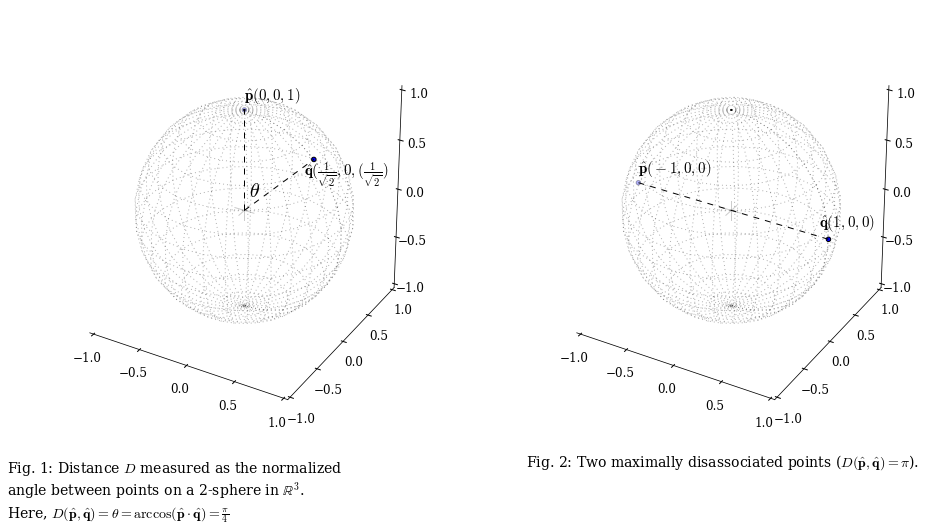

In [429]:
# Illustrate two example hyperspherical vectors
fig = plt.figure(figsize=(16,7.5))
ax1= fig.add_subplot(121, projection='3d')
drawsphere(ax1)
ir2 = 2.0**-0.5
ax1.scatter([0,ir2], [0,0], [1,ir2])
ax1.plot([0,0], [0,0], [0,1], c='k', linestyle='--')
ax1.plot([0,ir2], [0,0], [0,ir2], c='k', linestyle='--')
ax1.text(0.05, 0, 0.15, "$\\theta$", fontsize=20)
ax1.text(0,0, 1.1,
         "$\\mathbf{\\hat{p}} (0,0,1)$", fontsize=15)
ax1.text(ir2-.1, 0,ir2-.2,
         '$\\mathbf{\\hat{q}} '
         '(\\frac{1}{\\sqrt{2}},0,(\\frac{1}{\\sqrt{2}})$',
         fontsize=15)
fig.text(0.1, -0.05, 'Fig. 1: Distance $D$ measured as the normalized\n'
        'angle between points on a 2-sphere in $\mathbb{R}^3$.\n'
        'Here, $D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}}) = '
         '{\\theta} = \\arccos(\\mathbf{\\hat{p}}\\cdot\\mathbf{\\hat{q}})'
         ' = \\frac{\\pi}{4}$')

# Illustrate polar opposite points (maximal negative association)
ax2 = fig.add_subplot(122, projection='3d')
drawsphere(ax2)
ax2.scatter([-1,1], [0,0], [0,0])
ax2.plot([-1,1], [0,0], [0,0], c='k', linestyle='--')
ax2.text(-1,0,0.1,"$\\mathbf{\\hat{p}} (-1,0,0)$", fontsize=15)
ax2.text( 1-0.1,0,0.1,"$\\mathbf{\\hat{q}} (1,0,0)$", fontsize=15)
fig.text(0.55, 0.05, 'Fig. 2: Two maximally disassociated points'
         ' ($D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}}) = \\pi$).')
plt.show()

So we now have satisfying answers to our trivial cases: two purely associated points are co-located, two purely negatively associated points are at polar opposites *(Fig. 2)*, and two unassociated points can be at any two arbitrary locations.

This last rule seems the least satisfying. Should unassociated points be strictly at a neutral $D = \frac{\pi}{2}$? No, because this would imply that we have some knowledge about their association. For example, Alice might rate a film 5 stars, out of a range of 0 - 10. This knowledge of a neutral association would require us to place Alice's point at a distance of $\frac{\pi}{2}$ from the film's - all else being equal. But this will be a probabilistic system: the less we know about an association, the more *unpredictable* the corresponding distance should be. Intuitively it would seem that allowing arbitrary (random) placement to represent unknown assocations would lead to falsely implied associations due to accidental proximity, but using higher-dimensional spaces can mitigate this problem, as shown in the next section.

## The Choice of Dimensionality

The notion of the inherent probabilistic nature of the system suggests that randomness will need to play some role. How well will we know that a measured distance represents a well-defined association, as opposed to simple chance?

The severity of this problem depends on the distribution of possible distances, given a uniform distribution of points in the space. If a measured distance is statistically unlikely we would feel more confident of its significance. A high-dimensional space yields more of these statistically significant measurements from a given set of associations. Such spaces require larger vectors, which naturally contain more information. It follows intuitively that the more information stored in the system, the more insight might be gleaned from it.

This tradeoff between keeping vector sizes small and maximizing the certainty of predictions will be one of the main themes of this investigation.

### The Probability Distribution of Hyperspherical Distances

Let's explore the distribution of distances given a uniform distribution of points on the surface of a hypersphere. The problem can be simplified by taking a single point and considering the distribution of distances to other uniformly distributed points. This distribution will be the same for any point.

Given a two points $\mathbf{\hat{p}}$ and $\mathbf{\hat{q}}$, and a third point $\mathbf{\hat{r}}$ uniformly sampled on the surface, what is the probability that $D(\mathbf{\hat{p}},\mathbf{\hat{r}}) < D(\mathbf{\hat{p}},\mathbf{\hat{q}})$? Such a probability - or rather, its opposite - will be useful as a similarity measure.

This probability value is equivalent to proportion of the area of the *hyperspherical cap* described by the angle between points $\mathbf{\hat{p}}$ and $\mathbf{\hat{q}}$ to the area of the hypersphere as a whole (see *Fig 3*). This is because the cap contains all points closer to $\mathbf{\hat{p}}$ than $\mathbf{\hat{q}}$. The smaller the cap, the fewer closer points, and the smaller the probability that a uniformly sampled point would be at a shorter distance. Conversely, the higher the probability a uniformly sampled point would be at a longer distance.

In [430]:
def hs_length(vs):
    return np.linalg.norm(vs, axis=len(vs.shape)-1)
    
def hs_normalize(vs):
    shape = list(vs.shape)
    shape[-1] = 1
    return vs / hs_length(vs).reshape(shape)

def hs_sample(m, n):
    '''Returns m vectors uniformly sampled over the surface
    of a hypersphere in n-d space. Uses Marsaglia's algorithm.'''
    vs = np.random.standard_normal((m, n))
    return hs_normalize(vs)

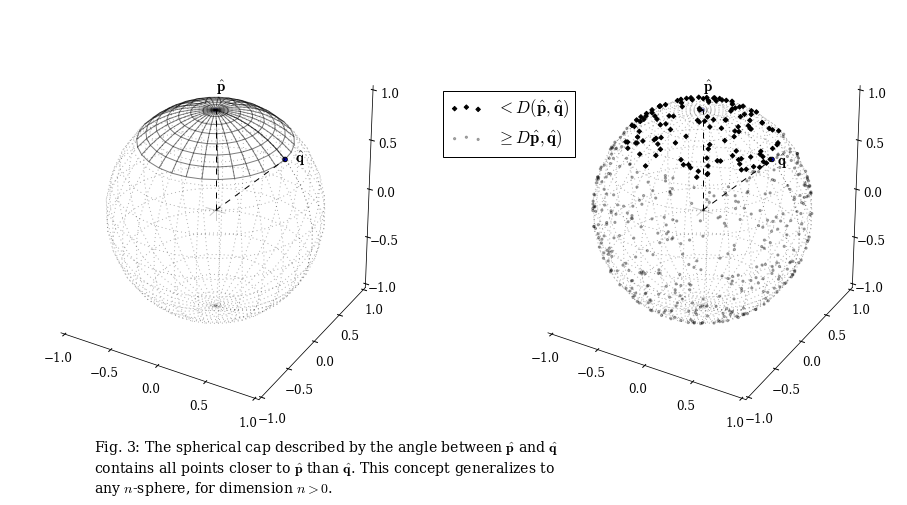

In [431]:
# Illustrate the correspondance between hyperspherical cap area
# and the chance a random point will be at a closer distance.
fig = plt.figure(figsize=(16,7.5))
ax1= fig.add_subplot(121, projection='3d')
drawsphere(ax1)
# Draw a spherical cap at an angle of pi/4
u, v = np.linspace(0, 2 * np.pi, 32), np.linspace(0, np.pi/4, 8)
ax1.plot_wireframe(np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v)),
                   np.outer(np.ones(np.size(u)), np.cos(v)),
                   color='k', linestyle='-', alpha=0.5)
ir2 = 2.0**-0.5
ax1.scatter([0,ir2], [0,0], [1,ir2])
ax1.plot([0,0], [0,0], [0,1], color='k', linestyle='--')
ax1.plot([0,ir2], [0,0], [0,ir2], color='k', linestyle='--')
ax1.text(0,0,1.175,"$\\mathbf{\\hat{p}}$", fontsize=15)
ax1.text(ir2+.1,0,ir2,'$\\mathbf{\\hat{q}}$', fontsize=15)

ax2= fig.add_subplot(122, projection='3d')
drawsphere(ax2)
np.random.seed(12345)
ps = hs_sample(1024, 3) # Sample some points
# Cull points on the backface of the sphere
t, p = np.radians(90 - ax2.elev), np.radians(ax2.azim)
atcam = np.array([sin(t) * cos(p), sin(t) * sin(p), cos(t)])
ps = ps[(ps * atcam).sum(1) > 0] # Dot product with vec pointing at camera
# Seperate out points inside or outside the cap
ips = ps[ps[:,2] > ir2]
ops = ps[ps[:,2] <= ir2]
ax2.scatter([0,ir2], [0,0], [1,ir2])
ax2.plot([0,0], [0,0], [0,1], color='k', linestyle='--')
ax2.plot([0,ir2], [0,0], [0,ir2], color='k', linestyle='--')
ax2.text(0,0,1.175,"$\\mathbf{\\hat{p}}$", fontsize=15)
ax2.text(ir2+.05,0,ir2-0.05,'$\\mathbf{\\hat{q}}$', fontsize=15)
ax2.scatter(ips[:,0], ips[:,1], ips[:,2],
            c='k', s=10, alpha=1.0, marker='D', label='$< D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$')
ax2.scatter(ops[:,0], ops[:,1], ops[:,2],
            c='k', s=5, alpha=0.3, marker='o', label='$\\geq D\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$')
plt.legend(bbox_to_anchor=(0.2, 0.8), borderaxespad=0.0)
fig.text(0.2, 0.0, 'Fig. 3: The spherical cap described by the angle between '
                    '$\\mathbf{\\hat{p}}$ and $\\mathbf{\\hat{q}}$\n'
                    'contains all points closer to $\\mathbf{\\hat{p}}$ '
                    'than $\\mathbf{\\hat{q}}$. This concept generalizes to\n'
                    'any $n$-sphere, for dimension $n > 0$.')
plt.show()    

[Li (2011)](http://scialert.net/fulltext/?doi=ajms.2011.66.70&org=11) provides a concise formula for calculating the area of a hyperspherical cap with an angle $0 < \theta < \frac{\pi}{2}$.

$$A_n^{cap}(r, \theta) = \frac{1}{2} A_n(r) I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)$$

$I$ is the *regularized incomplete beta function*. $A_n(r)$ is the area of a hypersphere of radius $r$ in $\mathbb{R}^n$, which we can factor out since we need only compute the proportion of the cap's area relative to the total area. We'll call this proportional value $A_n^{cap\prime}$

$$A_n^{{cap}^\prime}(\theta) = \frac{A_n^{cap}(r, \theta)}{A_n(r)} = \frac{1}{2}I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)$$

In [432]:
from scipy.special import betainc
#from mpmath import betainc
eps = np.finfo(float).eps
def hyperspherical_cap_proportion(angles, n):
    '''
    Calculates the proportion of the surface of a hypersphere covered
    by a 'hyperspherical cap' spanned by a certain angle.
    angles: array of angles in radians
    n: dimensions of the space, i.e., 3 for a 2-sphere
    From:
    S. Li , 2011. Concise Formulas for the Area and Volume of a
    Hyperspherical Cap. Asian Journal of Mathematics & Statistics, 4: 66-70.'''
    # Make sure we're measuring the smaller cap
    bigcap = angles > np.pi / 2
    sangles = angles * ~bigcap + (np.pi - angles) * bigcap
    result = betainc((n - 1) * 0.5, 0.5, np.sin(sangles)**2) / 2
    # Invert the results for the bigcaps
    result = result * ~bigcap + (1.0 - result) * bigcap
    return result

Given any two points on a hypersphere surface, we can now calculate the probability that a uniformly sampled point would be closer to the first than the second. A low probability near $0$ indicates a high degree of association, while a probability near $1$ indicates a high degree of negative association.

The hyperspherical cap proportion for an angle can be seen as the *cumulative distribution function* (CDF) for distances between pairs of uniformly sampled points on the surfaces of hyperspheres. It follows that its <a href="http://www.wolframalpha.com/input/?i=derivative+of+BetaRegularized%5Bsin(x)%5E2,+(n-1)%2F2,+1%2F2%5D+%2F+2">derivative</a> is the *probability density function* (PDF) for these distances.

$$
\frac{d}{d \theta}A_n^{{cap}^\prime}(\theta)
=
\frac{d}{d \theta}\left(\frac{1}{2}I_{\sin^2\theta}\left(\frac{n-1}{2},\frac{1}{2}\right)\right)
=
\frac
{\sin(\theta) \cos(\theta) \sin^2(\theta)^{\frac{n-1}{2} - 1}}
{\mathrm{B}\left(\frac{n-1}{2},\frac{1}{2}\right)\sqrt{1-\sin^2(\theta)}}
$$

$\mathrm{B}$ is the beta function.

In [433]:
from scipy.special import beta
#from mpmath import beta
def hyperspherical_angle_pdf(angles, n):
    '''
    Calculates the probability density function over the angles between
    pairs of uniformly sampled points on a hypersphere. This is the
    derivative of the hyperspherical cap proportion described by the angle.
    angles: array of angles in radians
    n: dimensions of the space, i.e., 3 for a 2-sphere
    From: http://www.wolframalpha.com/input/?i=derivative+of+BetaRegularized%5Bsin(x)%5E2,+(n-1)%2F2,+1%2F2%5D+%2F+2
          (sin(x) cos(x) sin^2(x)^((n-1)/2-1))/(beta((n-1)/2, 1/2) sqrt(1-sin^2(x)))
    '''
    # Make sure we're measuring the smaller cap
    x = np.clip(np.pi/2 - np.abs(np.pi/2 - angles), eps, np.pi / 2)
    sx, cx = np.sin(x), np.cos(x)
    hsn = (n - 1) / 2.0
    return ((sx * cx * ((sx**2)**(hsn - 1))) / (beta(hsn, 0.5) * np.sqrt(1 - sx**2)))

*Fig. 4* illustrates how the chance of a closer point changes with respect to angle for a selection of dimensionalities. From it we can conclude that given two random points on a 2D circle, or 3D sphere, there is a fair chance that they'll be closer than a distance of, say, $\frac{\pi}{4}$ (or $< 45^o$). But on a 12D hypersphere, the chance of this is extremely low.

In *Fig. 5* the distribution of distances make clearer the effect that higher dimensions have. Distances are much more likely to be clustered around $\frac{\pi}{2}$. That is, as dimensionality increases, points tend to be at near-orthogonal angles to eachother. Distances around $0$ or $\pi$ are increasingly unlikely to happen by chance, which for our purposes means they can be interpreted more significant.

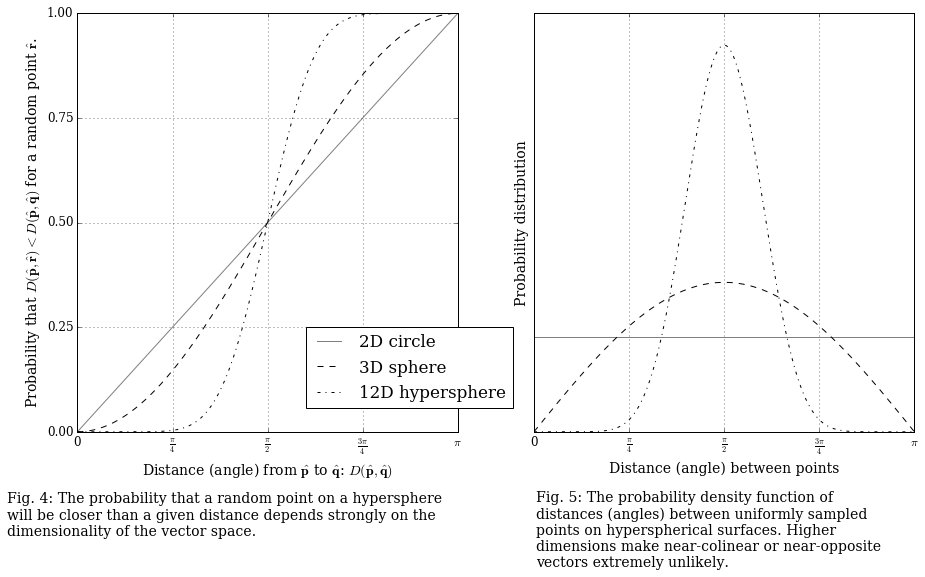

In [434]:
s = 512
dd = np.pi / (s - 1)
a = np.linspace(0.0, np.pi, s)

# Compute the CDFs of distances over angle.
cdf2 = hyperspherical_cap_proportion(a, 2)
cdf3 = hyperspherical_cap_proportion(a, 3)
cdf12 = hyperspherical_cap_proportion(a, 12)

# Compute the PDFs as a derivative
pdf2 = hyperspherical_angle_pdf(a, 2)
pdf3 = hyperspherical_angle_pdf(a, 3)
pdf12 = hyperspherical_angle_pdf(a, 12)

# Normalize PDFs
pdf2 /= (pdf2 * dd).sum()
pdf3 /= (pdf3 * dd).sum()
pdf12 /= (pdf12 * dd).sum()


fig = plt.figure(figsize=(15,7.5))
# Plot the CDFs
ax1 = fig.add_subplot(121)
ax1.plot(a, cdf2, c='k', linestyle='-', alpha=0.5, label='2D circle')
ax1.plot(a, cdf3, c='k', linestyle='--', label='3D sphere')
ax1.plot(a, cdf12, c='k', linestyle='-.', label='12D hypersphere')
ax1.grid()
ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{2}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax1.set_xlim((0, np.pi))
ax1.set_xlabel('Distance (angle) from $\\mathbf{\\hat{p}}$ to $\\mathbf{\\hat{q}}$: '
               '$D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$')
ax1.set_yticks([x/4. for x in range(5)])
ax1.set_ylabel('Probability that $D(\\mathbf{\\hat{p}},\\mathbf{\\hat{r}})'
               '<D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$ for a random '
               'point $\\mathbf{\\hat{r}}$.')
fig.text(0.06,-0.067, 'Fig. 4: The probability that a random point on a hypersphere\n'
                    'will be closer than a given distance depends strongly on the\n'
                    'dimensionality of the vector space.')
plt.legend(bbox_to_anchor=(0.6, 0.25), loc=2, borderaxespad=0.0)
# Plot the DDFs
ax2 = fig.add_subplot(122)
ax2.plot(a, pdf2, c='k', linestyle='-', alpha=0.5, label='2D circle')
ax2.plot(a, pdf3, c='k', linestyle='--', label='3D sphere')
ax2.plot(a, pdf12, c='k', linestyle='-.', label='12D hypersphere')
plt.grid()
ax2.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax2.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{2}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax2.set_xlim((0, np.pi))
ax2.set_yticks([])
ax2.set_xlabel('Distance (angle) between points')
ax2.tick_params(axis='y', which='both', left='off', labelleft='off')
ax2.set_ylabel('Probability distribution')
fig.text(0.55,-0.125, 'Fig. 5: The probability density function of\n'
                    'distances (angles) between uniformly sampled\n'
                    'points on hyperspherical surfaces. Higher\n'
                    'dimensions make near-colinear or near-opposite\n'
                    'vectors extremely unlikely.')

plt.show()

### A Probability-based Similarity Measure

We can now define a similarity measure for vectors representing points on unit hyperspheres based on this.

$$S(\mathbf{\hat{p}},\mathbf{\hat{q}}) = 1 - A_n^{{cap}^\prime}(D(\mathbf{\hat{p}},\mathbf{\hat{q}}))$$

$\mathbf{\hat{p}}$ and $\mathbf{\hat{q}}$ are vectors in $\mathbb{S}^{n-1}$.

This measure has the property that the distribution of similarity scores is uniform given a set of uniformly distributed points, independent of the dimensionality. We can expect 5% of measured similarities to be below 0.05. 10% will be above 0.9. Multiplying a similarity score by 100 gives a intuitive *percentile rank*. A similarity score of 0.9 seems high, but there is a 1-in-10 chance it could have been higher given a random point. But a similarity score of 0.9999 is so high that we could be confident in inferring an association between the corresponding objects in our system.

### Stochastic Confirmation of Distance and Similarity Distributions

In the preceding sections I made a claim as to the distribution of distances between uniformly sampled points on hyperspherical surfaces (*Fig 5.*) and a I also asserted that $S(\mathbf{\hat{p}},\mathbf{\hat{q}})$ would be distributed uniformly. I'll demonstrate that now using stochastic simulation.

In [435]:
# Here we define functions for computing the distances and similarities
# between (lists of) pairs of vectors.
def hs_dot(p, q):
    '''Returns the dot product between two (lists of) hyperspherical
    points.'''
    return (p * q).sum(len(p.shape) - 1)

def hs_angle(p, q):
    '''Returns the angle between two (lists of) hyperspherical points.'''
    return np.arccos(np.clip(hs_dot(p, q),-1.0, 1.0))

hs_distance = hs_angle

HS_CAPP_CACHE_SIZE = 4096
HS_CAPP_CACHE_INDEX = np.linspace(0, np.pi, HS_CAPP_CACHE_SIZE)
_hs_capp_cache = {}
def hs_capp(p, q):
    '''Returns the hyperspherical cap proportional area described by
    the angle between two (lists of) hyperspherical points.
    For performance, uses a cached look-up table for each n.'''
    n = p.shape[-1]
    angles = hs_angle(p, q)
    global _hs_capp_cache
    if n in _hs_capp_cache:
        lut = _hs_capp_cache[n]
    else:
        lut = hyperspherical_cap_proportion(HS_CAPP_CACHE_INDEX, n)
        _hs_capp_cache[n] = lut
    return np.interp(angles, HS_CAPP_CACHE_INDEX, lut)

def hs_similarity(p, q):
    '''Returns the similarity between two (lists of) hypersphere points.'''
    return 1 - hs_capp(p, q)

In [436]:
# Generate two lists of vectors, and measure their
# pairwise distances and similarities.
N = 24
NSAMPLES = 2**20
NBUCKETS = 2**5 + 1
SPB = float(NSAMPLES) / NBUCKETS
np.random.seed(54321)
ps = hs_sample(NSAMPLES, N)
qs = hs_sample(NSAMPLES, N)
d_tallies, dists = np.histogram(hs_distance(ps, qs), NBUCKETS, (0, np.pi))
s_tallies, sims = np.histogram(hs_similarity(ps, qs), NBUCKETS, (0, 1))

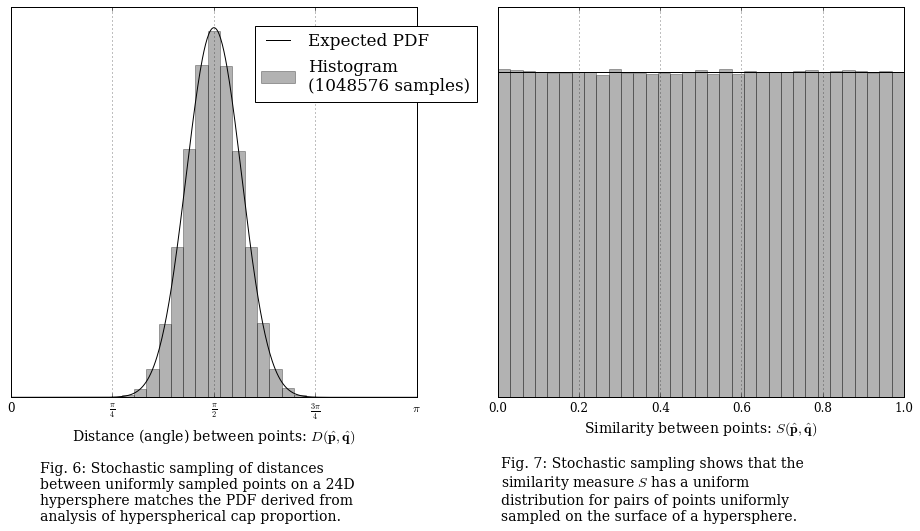

In [437]:
# Plot the PDF against the sampled histogram
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)

pdfN = hyperspherical_angle_pdf(a, N)
ax1.plot(a, pdfN, color='k', linestyle='-', label='Expected PDF')
ax1.bar(dists[:-1],
        d_tallies / (np.pi * SPB),
        color='k', alpha=0.3, width=np.pi / NBUCKETS,
        label="Histogram\n(%d samples)" % NSAMPLES)
ax1.grid()
ax1.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_xticklabels(['0', '$\\frac{\\pi}{4}$','$\\frac{\\pi}{2}$','$\\frac{3\\pi}{4}$','$\\pi$'])
ax1.set_xlim((0, np.pi))
ax1.set_xlabel('Distance (angle) between points: $D(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$')
ax1.set_yticks([])
ax1.tick_params(axis='y', which='both', left='off', labelleft='off')
fig.text(0.15,-0.12,
         'Fig. 6: Stochastic sampling of distances\n'
         'between uniformly sampled points on a %dD\n'
         'hypersphere matches the PDF derived from\n'
         'analysis of hyperspherical cap proportion.' % N)
plt.legend(bbox_to_anchor=(0.60, 0.95), loc=2, borderaxespad=0.0)

# Plot the sampled similarities to show a uniform distribution.
ax2 = fig.add_subplot(122)
ax2.plot([0,1], [1, 1], color='k', linestyle='-')
ax2.bar(sims[:-1],
        s_tallies / SPB,
        color='k', alpha=0.3, width=1.0 / NBUCKETS)
plt.grid()
ax2.set_xlim((0, 1))
ax2.set_yticks([])
ax2.set_xlabel('Similarity between points: $S(\\mathbf{\\hat{p}},\\mathbf{\\hat{q}})$')
ax2.tick_params(axis='y', which='both', left='off', labelleft='off')
fig.text(0.55,-0.12,
         'Fig. 7: Stochastic sampling shows that the\n'
         'similarity measure $S$ has a uniform\n'
         'distribution for pairs of points uniformly\n'
         'sampled on the surface of a hypersphere.')

plt.show()

# Mapping Associations to Vectors

Given a set of objects and a set of weighted associations between them, how do we map each object to a vector on a hypersphere such that the associations are retained in the similarities of the vectors? For now, we'll informally define *retention* as how strongly an association in the input data is reflected in the similarity measured between the corresponding object vectors after mapping.

First, let's consider a simpler problem. We'll assume that all but one of the objects but one have already been mapped to vectors. We have one object left and a list of weighted associations with a subset of the objects already in the system. How do we map this one object to a vector?

## Weighted Hyperspherical Means

Given our definition of retention, we'll define our goal as maximizing the weighted mean similarity between the new object's vector and each of the associated vectors. An obvious solution is to compute the weighted mean of the associated vectors. This can't be done trivially or uniquely on a hyperspherical surface.

A cheap and reasonable estimate is to take the weighted Eucliean centroid of the vectors and normalize the result.

$$NEC(\{\mathbf{\hat{v}}_1, ... \mathbf{\hat{v}}_m\}, \{w_1, ... w_m\}) =
\widehat{\displaystyle\sum_{i=1}^{m} (w_i\cdot\mathbf{\hat{v}}_i)}$$

Here a $\widehat{\mathrm{hat}}$ is the normalization operation such that $\mathbf{\hat{v}} = \frac{\mathbf{v}}{\left\|\mathbf{v}\right\|}$.

This approximation generates incorrect results, for example when taking the mean of widely-spaced points of unequal weights. Say the weight of $\mathbf{\hat{p}}$ is $2$ and the weight of $\mathbf{\hat{q}}$ is $1$. Their weighted mean should be half the distance from $\mathbf{\hat{p}}$ than it is from $\mathbf{\hat{q}}$ along the geodesic between them. But the normalized Euclidean centroid will place it closer to $\mathbf{\hat{p}}$. See *Fig 8*.

In [438]:
# We'll use this in our illustration and define it shortly.
DP_THRES = 0.9999
def hs_slerp(p, q, t):
    ''' A spherical linear interpolation between points
    on a hypersphere.
    See: https://en.wikipedia.org/wiki/Slerp'''
    dp = hs_dot(p, q)
    pm = p.shape[0] if len(p.shape) > 1 else 1
    qm = q.shape[0] if len(q.shape) > 1 else 1
    a = np.arccos(dp)
    sa = np.sqrt(1 - np.square(dp)) # np.sin(a)
    ta = t * a
    sta = np.sin(ta)
    sita = np.sin(a - ta)
    r = (sita/sa).reshape((qm, 1)) * p + (sta/sa).reshape((qm, 1)) * q
    nans = np.isnan(r)
    r[nans] = q.reshape(r.shape)[nans] # Nans happen with p == q, so sa == 0
    return r

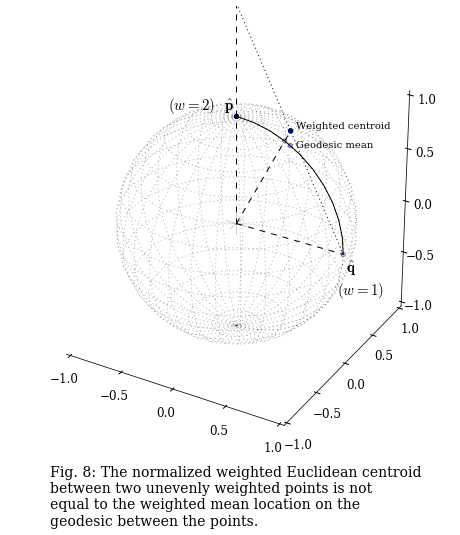

In [439]:
# Illustrate the incorrect results generated by a normalized
# weighted Euclidean mean.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
drawsphere(ax1)
p = np.array([0.,0,1.0])
q = np.array([1.,0,0])
geodesic = np.array([hs_slerp(p, q, i/10.)[0] for i in range(11)])
sm = hs_slerp(p, q, 1.0/3)[0]
em = (p*2 + q*1) / 2.0
nec = hs_normalize(em)
ax1.scatter([0,1], [0,0], [1,0], color='k')
ax1.plot([0,0], [0,0], [0,2], color='k', linestyle='--')
ax1.text(-0.65,0,0.9,"$(w = 2)$  $\mathbf{\\hat{p}}$", fontsize=15)
ax1.plot([0,1], [0,0], [0,0], color='k', linestyle='--')
ax1.text(0.95,0,-0.4,'  $\\mathbf{\\hat{q}}$\n$(w = 1)$', fontsize=15)
ax1.plot([0,1], [0,0], [2,0], color='k', linestyle=':')
ax1.plot([0,em[0]], [0,em[1]], [0,em[2]], color='k', linestyle='--')
ax1.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], color='k')
pts = np.array([sm, em, nec])
ax1.scatter(pts[:,0], pts[:,1], pts[:,2], color='k')
ax1.text(em[0]+.05,em[1],em[2]+0.04,'Weighted centroid', fontsize=10)
ax1.text(sm[0]+.05,sm[1],sm[2]+0.0,'Geodesic mean', fontsize=10)
#plt.legend(bbox_to_anchor=(0.2, 0.8), borderaxespad=0.0)
fig.text(0.2, 0.0, 'Fig. 8: The normalized weighted Euclidean centroid\n'
                   'between two unevenly weighted points is not\n'
                   'equal to the weighted mean location on the\n'
                   'geodesic between the points.')
plt.show()    

A more appropriate mean is the *Fréchet mean* (FM). It is defined as the point which minimizes the sum of the squared geodesic distances to the input points. It is not trivial to compute, nor is it necessarily unique.

[Salehian et al., 2015](https://www-sop.inria.fr/asclepios/events/MFCA15/Papers/MFCA15_4_2.pdf) describe a simple and efficient technique for esimating the FM on hyperspheres called the *incremental Fréchet Mean Estimator*, or $iFME$. It recursively builds up the FM by starting with the first point, then moving along the shortest geodesic path to the next point by a distance proportion to the second point's weight relative to their summed weight. This repeated using the new point and summed weight as input, moving it toward the third point, and so on. We'll extend Salehian et al.'s defintion to include an input weight for each vector.

We'll use spherical linear interpolation, or $Slerp$ ([Shoemake, 1985](http://run.usc.edu/cs520-s12/assign2/p245-shoemake.pdf)), to implement our weighted translations along the shortest geodesic.

$$
Slerp(\mathbf{\hat{p}},\mathbf{\hat{q}};t) =
\frac{\sin( (1-t)\theta)}{\sin\theta}\mathbf{\hat{p}} + \frac{\sin(t\theta)}{\sin\theta}\mathbf{\hat{q}} \quad,\quad \theta = D(\mathbf{\hat{p}},\mathbf{\hat{q}})
$$

Given a set of input vectors $\{\mathbf{\hat{v}}_1, \dots \mathbf{\hat{v}}_m\}$ and a set of weights $\{w_1, \dots w_m\}$, $iFME$ incrementally generates a mean.

$$
\begin{aligned}
iFME_1 &= \mathbf{\hat{v}}_1 \\
iFMEW_1 &= w_1 \\
iFME_m &= Slerp(iFME_{m-1}, \mathbf{\hat{v}}_m; \tfrac{w_m}{iFMEW_{m-1}}) \\
iFMEW_m &= iFMEW_{m-1} + w_m \\
\end{aligned}
$$

This technique has the useful property that the mean can be updated when new data arrives without recomputing from the entire data set. This should prove valuable in practical applications of the system described in this paper, but for now I will assume all the points and weights are available for the mean function.

I will modify the $iFME$ algorithm to $Slerp$ pairs of points in the input set, recursively generating a smaller set until a single vector remains. In this way a mean is built from progressively larger pieces. This has the advantage of lending itself to a parallel *MapReduce*-style implementation, and possibly spreads the problem of numeric inprecision across the data rather than biasing it to the latter points (this property is yet to be demonstrated).

Let's define an operation to apply *Slerp* pairwise to a set of vectors and associated weights. Here $m$ must be positive and even, and the operation returns a new set of vectors $\{\hat{P}_1, \dots \hat{P}_m\}$ and weights $\{PW_1, \dots PW_m\}$ exactly half the size. If a weight is negative, we use its absolute value but reverse  the corresponding vector.

$$
\begin{aligned}
\hat{P}_i &= Slerp(\dfrac{w_{2i-1}}{\left|w_{2i-1}\right|} \mathbf{\hat{v}}_{2i-1},\dfrac{w_{2i}}{\left|w_{2i}\right|} \mathbf{\hat{v}}_{2i}; \tfrac{\left|w_{2i}\right|}{\left|w_{2i-1}\right| + \left|w_{2i}\right|}) \\
{PW}_i &= \left|w_{2i-1}\right| + \left|w_{2i}\right| \\
\end{aligned}
$$

We can define our *pairwise Fréchet Mean estimator* ($pFME$) as follows.

$$
pFME(\{\mathbf{\hat{v}}_1, \dots \mathbf{\hat{v}}_m\}, \{w_1, \dots w_m\}) =
\begin{cases}
(\mathbf{\hat{v}}_1, w_1) & \quad \text{if } m = 1 \\
pFME(\{\hat{P}_1, \dots \hat{P}_{\frac{m}{2}}\}, \{{PW}_1, \dots {PW}_{\frac{m}{2}}\}) & \quad \text{if } m \text{ is even} \\
pFME(\{\hat{P}_1, \dots \hat{P}_{\frac{m-1}{2}},\mathbf{\hat{v}}_m\}, \{{PW}_1, \dots {PW}_{\frac{m-1}{2}}, w_m\}) & \quad \text{if } m \text{ is odd} \\
\end{cases}
$$

In [689]:
# Implement the three hyperspherical mean
# approximations defined above.
def hs_nemean(vs, ws=None):
    '''Normalized euclidian centroid of a set of weighted
    hyperspherical vectors.'''
    wvs = vs * ws[:,None] if ws is not None else vs
    return hs_normalize(np.array([wvs.sum(0)]))[0]

def hs_ifmean(vs, ws=None, posw=False):
    '''Incremental Fréchet Mean estimation of a weighted set
    of hyperspherical vectors.'''
    if len(vs.shape) == 1: # We've been passed a single vector
        vs = vs.reshape(1,len(vs))
    if ws is None:
        ws = np.ones(vs.shape[0], dtype=np.float)
        aws = ws
        fvs = vs
    else:
        ss = np.sign(ws) # Positive or negative 1.
        aws = ws * ss # Absolute weights
        fvs = vs * ss.reshape(len(ss),1) # Flipped negative vectors
    m, t = fvs[0], aws[0]
    for v, w in zip(fvs[1:], aws[1:]):
        t += w
        m = hs_slerp(m, v, w/t)[0]
    return m

def hs_pfmean(vs, ws=None, posw=False):
    '''Pairwise Fréchet Mean estimation of a weighted set
    of hyperspherical vectors by recursively slerping pairs
    together until one vector remains.'''
    if len(vs.shape) == 1: # We've been passed a single vector
        vs = vs.reshape(1,len(vs))
    m, n = vs.shape
    if ws is None:
        ws = np.ones(m, dtype=np.float)
        posw = True
    if posw:
        aws = ws
        fvs = vs
    else:
        ss = np.sign(ws) # Positive or negative 1.
        aws = ws * ss # Absolute weights
        fvs = vs * ss.reshape(len(ss),1) # Flipped negative vectors
    if m == 1:
        return fvs[0]
    if m % 2 == 0: # An even number, slerp each pair!
        vs1, vs2 = fvs[::2], fvs[1::2]
        ws1, ws2 = aws[::2], aws[1::2] 
        sws = ws1 + ws2
        # Flip any vectors with negative weights
        svs = hs_slerp(vs1, vs2, ws2 / sws)
    else: # An odd number, remove the first element,
          # slerp the rest, then append the first at the end
        vs1, vs2 = fvs[1::2], fvs[2::2]
        ws1, ws2 = aws[1::2], aws[2::2]
        # Preallocate arrays
        m2 = m/2 + 1
        svs = np.empty((m2, n))
        sws = np.empty(m2)
        sws[:-1] = ws1 + ws2
        sws[-1] = aws[0]
        # Flip any vectors with negative weights
        svs[:-1] = hs_slerp(vs1, vs2, ws2 / sws[:-1])
        svs[-1] = fvs[0]
    return hs_pfmean(svs, sws, True) # Recurse with the smaller list

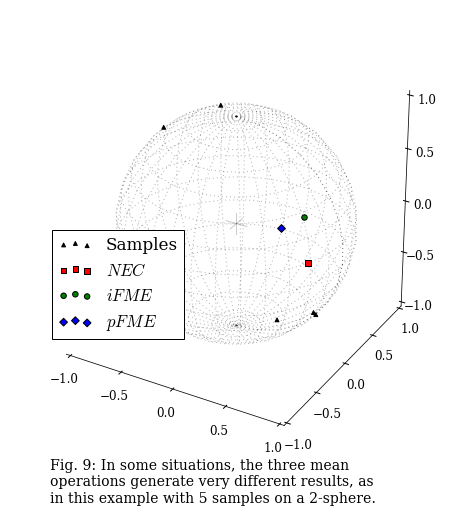

In [576]:
# Illustrate the results of applying the three mean operations.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
drawsphere(ax1)
np.random.seed(4)
vs = hs_sample(5, 3)
x  = hs_normalize(np.array([[1,-1,1]]))
vs = hs_slerp(x, vs, 0.6) # Cluster very loosely.
nemean = hs_nemean(vs)
ifmean = hs_ifmean(vs)
pfmean = hs_pfmean(vs)
ax1.scatter(vs[:,0],vs[:,1],vs[:,2], c='k', s=15, alpha=1.0, marker='^',
            label='Samples')
ax1.scatter(nemean[0],nemean[1],nemean[2],
            c='r', s=30, alpha=1.0, marker='s', label="$NEC$")
ax1.scatter(ifmean[0],ifmean[1],ifmean[2],
            c='g', s=30, alpha=1.0, marker='o', label="$iFME$")
ax1.scatter(pfmean[0],pfmean[1],pfmean[2],
            c='b', s=30, alpha=1.0, marker='D', label="$pFME$")
plt.legend(bbox_to_anchor=(0.10, 0.5), loc=2, borderaxespad=0.0)
fig.text(0.2, 0.04, 'Fig. 9: In some situations, the three mean\n'
                   'operations generate very different results, as\n'
                   'in this example with 5 samples on a 2-sphere.')
plt.show()

As can be seen in *Fig 9*, the three mean operations can generate significantly different results. We need a way to evaluate which is the most retentive. That is, we want to know which best preserves the input associations in the similarities of the mapped vectors. The more vectors in the set, the less we can expect a similarity to be strongly retained for a particular vector in the set. We can investigate how each mean operation performs in this regard.

We'll test this stochastically for a range of vector set sizes and dimensionalities.

In [577]:
Ns = [3, 16, 64]          # Dimensionalities to try
Ms = np.arange(1, 101, 4) # Sizes of the vector pool
Ts = np.arange(64)        # The number of tests to run
Os = [hs_nemean,          # Mean operations to test
      hs_pfmean,
      hs_ifmean]

In [578]:
results = np.zeros((len(Ns), len(Ms), len(Ts), len(Os)))
np.random.seed(101)
for Ni, N in enumerate(Ns):
    for Mi, M in enumerate(Ms):
        for Ti, T in enumerate(Ts):
            # Sample some vectors
            vs = hs_sample(M, N)
            # Sample some random weights
            ws = np.random.exponential(10, M) + 1
            #ws = np.ones(M) # Uniform weights
            for Oi, O in enumerate(Os):
                # Get the mean similarity between a mean and each input vector
                s = hs_similarity(vs, O(vs, ws))
                # Record the weighted mean similarity
                results[Ni,Mi,Ti,Oi] = (s * ws).sum() / ws.sum()
# Generate the mean across each of the tests
results = results.mean(axis=2) # Axis 2 is Ts

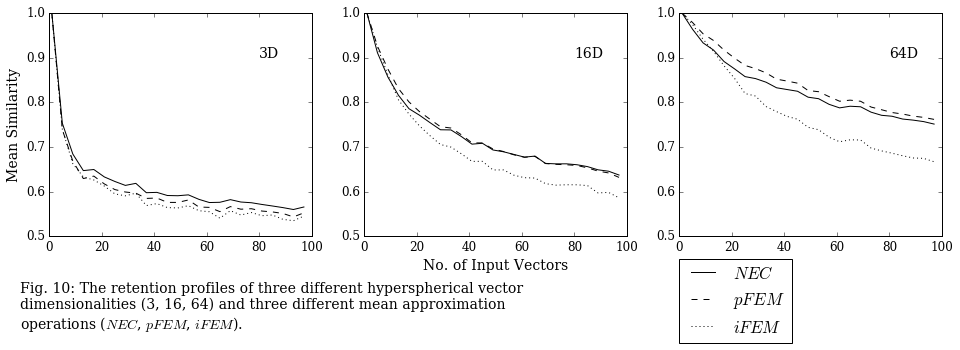

In [579]:
# Plot retention of different dimentionalities and mean operations
fig = plt.figure(figsize=(16,4))
# 3D
ax1 = fig.add_subplot(131)
ax1.set_ylim((0.5,1))
ax1.set_ylabel('Mean Similarity')
ax1.text(80, 0.9, '%dD' % Ns[0])
ax1.plot(Ms, results[0,:,0], label='$NEC$', color='k')
ax1.plot(Ms, results[0,:,1], label='$pFEM$', color='k', linestyle='--')
ax1.plot(Ms, results[0,:,2], label='$iFEM$', color='k', linestyle=':')

ax2 = fig.add_subplot(132)
ax2.set_ylim((0.5,1))
ax2.set_xlabel('No. of Input Vectors')
ax2.text(80, 0.9, '%dD' % Ns[1])
ax2.plot(Ms, results[1,:,0], label='$NEC$', color='k')
ax2.plot(Ms, results[1,:,1], label='$pFEM$', color='k', linestyle='--')
ax2.plot(Ms, results[1,:,2], label='$iFEM$', color='k', linestyle=':')

ax3 = fig.add_subplot(133)
ax3.set_ylim((0.5,1))
ax3.text(80, 0.9, '%dD' % Ns[2])
ax3.plot(Ms, results[2,:,0], label='$NEC$', color='k')
ax3.plot(Ms, results[2,:,1], label='$pFEM$', color='k', linestyle='--')
ax3.plot(Ms, results[2,:,2], label='$iFEM$', color='k', linestyle=':')
plt.legend(bbox_to_anchor=(0.0, -0.1), loc=2, borderaxespad=0.0)

fig.text(0.1,-0.2,
         'Fig. 10: The retention profiles of three different hyperspherical vector\n'
         'dimensionalities (3, 16, 64) and three different mean approximation\n'
         'operations ($NEC$, $pFEM$, $iFEM$).')

plt.show()

Several interesting observations can be made from these results. Firstly, and least surprisingly, higher-dimensional systems exhibit significantly better retention. For ten 64D vectors, a mean similarity of over 0.95 can be retained, and around 0.75 for 100. This is a promising result. At lower dimensions the three mean estimates perform similarly, with $NEC$ the most effective by a small margin. At higher dimensions, however, $pFEM$ performs the best for small numbers of input vectors, but converges with $NEC$ with a large number of input vectors. $iFEM$'s retention drops more steeply as the number of input vectors increases, perhaps due to compounded precision errors.

It's worth noting that using uniformly sampled vectors for this test is simulating a kind of worse-case scenario, and it is surprising that the mean similarities don't converge more quickly toward 0.5. In practical applications one would expect the associated vectors to be already significantly similar with one another - if the data had no such underlying signals, there would be little point in utilising such a system. As such, real world retention could be significantly higher.

Not shown here, but easily replicated, is the difference made by using uniform weights. In that situation, at high dimensions, the $NEC$ and $pFEM$ estimates perform almost equally well, and $iFEM$ falls further behind.

Also of interest is the resemblance these retention curves bear a resemblance to the [forgetting curve](https://en.wikipedia.org/wiki/Forgetting_curve), a classic hypothesis from psychology ([Ebbinghaus, 1885](http://psychclassics.yorku.ca/Ebbinghaus/index.htm)) that postulates the retention of memory as $R = e^{-\frac{t}{S}}$, where $R$ is retention, $t$ is time, and $S$ is the strength of the memory.

Based on these results, going forward I will use $pFEM$ as the mean operation for hyperspherical vectors unless otherwise stated.

## Retention, Vector Pool Size and Dimensionality

There is a clear correlation between the dimensionality of the vector space ($n$) and the number of vectors ($m$) that can be merged by a mean operation while retaining a certain mean similarity. This correlation turns out to be linear.

We'll define the ratio between $m$ and $n$ as the *saturation* ($s$) of an instance of a mean operation.

$$s = \frac{m}{n}$$

A saturation of $1$, where $m=n$, serves as a natural single point to test retention. We'll now examine the retention curves again, this time against satutation (*Fig. 11*).

In [580]:
# Plot a variety of dimensionalities with
# the same range of saturations.
Ns = np.array([8, 32, 128])         # Dimensionalities to try
Ps = np.arange(-3,8, dtype=np.int)  # Relative sizes of the vector pool
Ts = np.arange(32)                  # The number of tests to run

# Vector pool sizes
Ms = np.array([[N*2**P for P in Ps] for N in Ns], dtype=np.int)
# Corresponding saturations
Ss = 2**Ps.astype(float)

In [581]:
results = np.zeros((len(Ns), len(Ps), len(Ts)))
np.random.seed(37373)
for Ni, N in enumerate(Ns):
    for Mi, M in enumerate(Ms[Ni]):
        s = Ss[Mi]
        #print (Ni, N), (Mi, M), s
        for Ti, T in enumerate(Ts):
            # Sample some vectors
            vs = hs_sample(M, N)
            # Sample some random weights
            ws = np.random.exponential(10, M) + 1
            #ws = np.ones(M) # Uniform weights
            sim = hs_similarity(vs, hs_pfmean(vs, ws))
            # Record the weighted mean similarity
            results[Ni,Mi,Ti] = (sim * ws).sum() / ws.sum()
# Generate the mean across each of the tests
results = results.mean(axis=2)

In [582]:
# Sample cases where saturation = 1 (M = N)
Ns2 = np.arange(2, 257, 4) # Dimensionalities to try
Ms2 = Ns2                  # Saturation = 1
Ts2 = np.arange(32)        # The number of tests to run
Os2 = [hs_nemean,          # Mean operations to test
       hs_pfmean,
       hs_ifmean]

In [583]:
results2 = np.zeros((len(Ns2), len(Ts2), len(Os2)))
np.random.seed(4390)
for Ni, N in enumerate(Ns2):
    Mi, M = Ni, N
    for Ti, T in enumerate(Ts2):
        # Sample some vectors
        vs = hs_sample(M, N)
        # Sample some random weights
        ws = np.random.exponential(10, M) + 1
        #ws = np.ones(M) # Uniform weights
        for Oi, O in enumerate(Os2):
            # Get the mean similarity between a mean and each input vector
            s = hs_similarity(vs, O(vs, ws))
            # Record the weighted mean similarity
            results2[Ni,Ti,Oi] = (s * ws).sum() / ws.sum()
# Generate the mean across each of the tests
results2 = results2.mean(axis=1) # Axis 2 is Ts

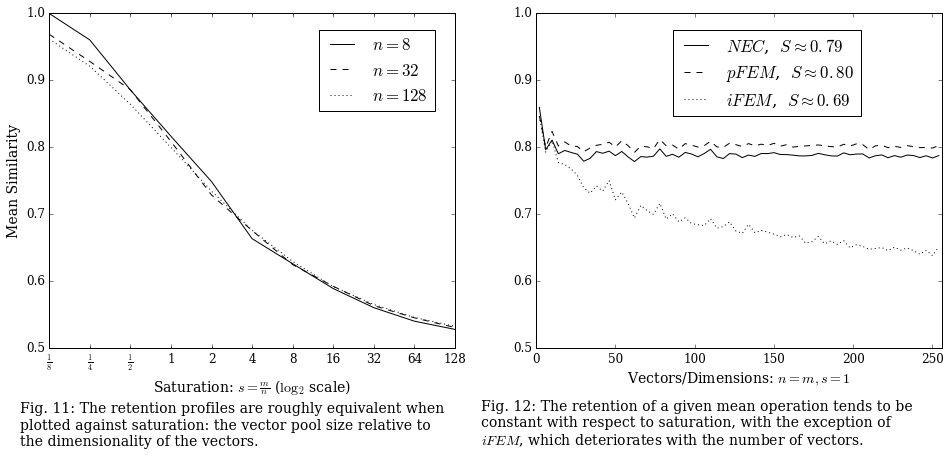

In [584]:
# Plot retention of different dimentionalities and mean operations
fig = plt.figure(figsize=(16,6))
# 3D
ax1 = fig.add_subplot(121)
ax1.set_ylim((0.5,1))
#ax1.set_xlim((0,128))
ax1.set_ylabel('Mean Similarity')
ax1.set_xlabel('Saturation: $s=\\frac{m}{n}$ ($\\log_2$ scale)')
ax1.set_xscale("log", basex=2)
ax1.set_xticks(Ss)
ax1.set_xticklabels(['$\\frac{1}{%d}$' % (1/S) if S < 1 else '%d'% S for S in Ss])
ax1.plot(Ss, results[0], label='$n = %d$' % Ns[0], color='k')
ax1.plot(Ss, results[1], label='$n = %d$' % Ns[1], color='k', linestyle='--')
ax1.plot(Ss, results[2], label='$n = %d$' % Ns[2], color='k', linestyle=':')
plt.legend(bbox_to_anchor=(0.95, 0.95), borderaxespad=0.0)

fig.text(0.1,-0.1,
        'Fig. 11: The retention profiles are roughly equivalent when\n'
        'plotted against saturation: the vector pool size relative to\n'
        'the dimensionality of the vectors.')

ax2 = fig.add_subplot(122)
ax2.set_ylim((0.5,1))
ax2.set_xlim((0,256))
ax2.set_xlabel('Vectors/Dimensions: $n = m, s = 1$')
ax2.plot(Ns2, results2[:,0], color='k',
         label='$NEC$,  $S \\approx %.2f$' % results2[:,0].mean())
ax2.plot(Ns2, results2[:,1], color='k', linestyle='--',
         label='$pFEM$,  $S \\approx %.2f$' % results2[:,1].mean())
ax2.plot(Ns2, results2[:,2], color='k', linestyle=':',
         label='$iFEM$,  $S \\approx %.2f$' % results2[:,2].mean())
plt.legend(bbox_to_anchor=(0.8, 0.95), borderaxespad=0.0)

fig.text(0.5,-0.1,
        'Fig. 12: The retention of a given mean operation tends to be\n'
        'constant with respect to saturation, with the exception of\n'
        '$iFEM$, which deteriorates with the number of vectors.')

plt.show()

We can also see (*Fig. 12*) that the mean similarity of a set of uniformly sampled vectors to its mean is constant, independent of the number of dimensions $n$. It's an interesting result that collapsing $n$ $n$-dimensional vectors into a single $n$-dimensional vector can retain a mean similarity to the originals representing about 80% confidence of assocation. This is in the *worst* case, where the input vectors are uniformly distributed - that is, completely unassociated with one another.

Clearly, using more dimensions means better retention, and presumably a more robust model of the object assocations to be mapped. The choice of how many dimensions to use then becomes a question of storage and processing resources. How much storage do we want to allocate for each vector? This raises the natural question of how to reduce the storage requirements of each element of the vector. Followed to its logical extreme, this leads to the idea of using bit strings, where a single bit is used for each dimension. I will explore this extreme tradeoff between dimensionality and data quantisation later (in the experiments so far, I've been using conventional 64-bit floats). But first, I need to complete the mapping algorithm.

## Bootstrapping a Vector Mapping

Even supposing we've chosen our our vector space, dimensionality and a mean operation, it remains to be seen how we can map a set of objects and their associations to vectors "from scratch". Unlike many machine learning techniques, our vector values aren't generated from the properties of the objects. Our only input is the *relationships* between them, and our output is meaningful only in the *relative* similarity of the vectors, and not their absolute values.

The input is a list of weighted bidirectional associations between pairs from a set of $m$ objects. The weight of association between objects $i$ and $j$ is denoted $w_{i,j}$, and as a rule, $w_{i,j} = w_{j,i}$ and $w_{i,i}$ = 0. The weight of an unassociated pair can be considered $0$.

I'll define a new property $\mu$ for each object, which is the sum of the absolute weights of all its associations. This can be thought of as its *mass*, by analogy to gravitational attraction.

$$\mu_i = \displaystyle\sum_{j=1}^{m} \left|w_{i,j}\right|$$

It has already been shown that as dimensionality increases, two randomly sampled points on a hypersphere are likely to be near-orthogonal to eachother. They are vanishingly unlikely to be very near or very far from eachother along the shortest geodesic. As such, any slight bias toward or away from eachother will be captured strongly in the similarity measure $S$ defined earlier. So I'll begin by assigning each object a vector sampled uniformly over the surface of the hypersphere. I will use simple random sampling, but other approaches could be considered. This suitably represents a kind of zero-information starting point, and I'll denote this first set of vectors as $\{\mathbf{\hat{v}}_{1,0}, \dots \mathbf{\hat{v}}_{m,0}\}$, where the second index $_0$ indicates the recursion depth. We'll call this set "generation $0$".

$$\mathbf{\hat{v}}_{i,0} \gets \mathbb{S}^{n-1}$$

We can now begin recursively refining the vectors. We'll first define a vector for each association, or *relation*, between objects. Here $\mathbf{\hat{r}}_{i,j,k}$ represents the relation between objects $i$ and $j$ at generation $k$, and is the mean of $\mathbf{\hat{v}}_{i,k}$ and $\mathbf{\hat{v}}_{j,k}$ weighted by their corresponding masses ($\mu$).

$$\mathbf{\hat{r}}_{i,j,k} = M(\{\mathbf{\hat{v}}_{i,k}, \mathbf{\hat{v}}_{j,k}\}, \{\mu_i, \mu_j\})
$$

Here $M$ is a mean operation like one of those defined above, such as $pFEM$. Note that these relation vectors are undefined if both objects have 0 mass. They will only have an effect on the computation if there is a non-zero weight on the corresponding association in the input data, in which case both objects must have non-zero mass, so there is no implementational need to handle the undefined cases.

With these relation vectors we can generate the next set of object vectors by taking their weighted mean for each object.

$$\mathbf{\hat{v}}_{i,k}
=
M(\{\mathbf{\hat{r}}_{i,1,{k-1}}, \dots \mathbf{\hat{r}}_{i,m,{k-1}}\},
  \{w_{i,1}, \dots w_{i,m}\})
$$

Another way to formulate this is to, for each object, generate a mean $\mathbf{\hat{c}}$ of all related object vectors, weighted by the product of the relation weight and the related object mass. It is by analogy a weighted center of gravity for the related objects.

$$\mathbf{\hat{c}}_{i,k}
=
M(\{\mathbf{\hat{v}}_{1,{k}}, \dots \mathbf{\hat{v}}_{m,{k}}\},
  \{w_{i,1}\mu_1, \dots w_{i,m}\mu_m\})
$$

Let us also define another object property $\sigma$ as an extension of $\mu$, the sum of each relation's weight multiplied by the $\mu$ of the related object. That is, it is the total weight used in the mean operation above.

$$\sigma_i = \displaystyle\sum_{j=1}^{m} \left|w_{i,j}\right|\mu_{j}$$

The center of gravity can then be blended with the object's current vector in the following way to simulate a generational "step".

$$\mathbf{\hat{v}}_{i,k}
=
M(\{\mathbf{\hat{v}}_{i,{k-1}}, \mathbf{\hat{c}}_{i,{k-1}}\},
  \{\mu_i^2, \sigma_i\})
$$


### An Intuitive Description

I'll try to build an intuitive case for why this approach could be effective and begin by describing what is happening. Each object vector $\mathbf{\hat{v}}_{i,k}$ in generation $k$ is a weighted combination of its direct predecessor $\mathbf{\hat{v}}_{i,k-1}$ as well as the vectors in generation $k-1$ of all the associated objects. 

First, note the inherent "playing chase" quality: each vector shifts towards its associated vectors, but those vectors are also moving elsewhere. The weighting scheme defined above is designed to balance this effect. A significant component of $\mathbf{\hat{v}}_{i,k}$ is its predecessor $\mathbf{\hat{v}}_{1,k-1}$, in fact it has exactly half the total weight when each object has an equal number of assocations and all associations have equal weight.

Consider that associated vectors are likely to be moving toward eachother, especially if they have few competing associations. In the extreme case of a pair of associated objects with no other associations, their vectors will be equal in generation $1$ (and equal to that relation vector) and won't move thereafter. For any subset of objects with a size larger than $2$ in which each member is associated with every other member, but with no objects outside the subset, the vectors will converge toward the subset mean. Although this property may not be very practically useful, it reflects a truth in the input data.

More massive or influential vectors - those with many or high-weight associations - move the least, since moving them would introduce the most error for the many vectors trying to reach them. Conversely low-mass vectors move the most, moving to the epicentre of their few associations.

All this should have the result of moving associated objects closer to eachother, and importantly, dragging indirectly associated vectors close together.

### A Concrete Example

As an example, consider the preference-prediction system outlined in the introduction that tries to guess a user's preferences for many things after being provided with a small set of of those preferences by the user. In such a system, we could expect the vectors representing preferenced concepts (say, music genres or cuisines) to be high-mass, since many thousands of users may have expressed preferences for them. Conversely the vectors representing users would be relatively low mass, since each individual user may only indicate a handful or preferences.

Say there is a real-world correlation in prefernces between two concepts, such as jazz music and Cajun cuisine, that is not directly represented in the input data. If such a correlation exists, we would expect an statistically significant proportion of the users who express a preference for one to express a preference for the other. All else being equal, the vectors for these users would, in generation $1$, end up somewhere "in between" the vectors for jazz and Cajun food. Since the combined weight of these users is significant, we can imagine this cohort of user vectors pulling the two concept vectors toward eachother in generation $2$. By then it should be possible to test for this correlation by measuring the similarity between the jazz and Cajun vectors.

Such an effect could be achieved in a film recommender engine, pulling films that are loved by simlar people together, without needing to know anything about their generes, stars or other properties. New users would be placed near films they know they love, and other unknown films in the same vector region could be recommended. Such a system might find use in another common application, medical diagnosis, where diseases, symptoms are patients are entered into the system with their known associations. New patients are added, associated with their symptoms, and the subsequent similarities with diseases might provide clues to further treatment.

We could expect these effects even in a system in which there are thousands of objects, interacting in complex ways. People are multidimensional beings. Someone may be an outlier in one aspect of their lives - bucking the trend of their demographic. But given a sufficiently multidimensional vector space, such exceptions can be accomodated for, and corner of the hypersphere can be found for them.

Importantly, we do not need up-front to decide what each of these dimensions represents, we need only decide how many we can afford to have.

In [692]:
# Complete the algorithm
import pandas as pd

def relsort(rels):
    '''Given a list of weighted relationships between object
    indices, returns a standard DataFrame indexed by
    each unique id, then each connection for each id,
    to give a weight for the relation. Removes reflexive
    relations and sums duplicates.'''
    # Shuffle relationships so that they are unique,
    # summing the weights of duplicated, and removing
    # and reflexive relations.
    relsn = pd.DataFrame(rels[(rels['w'] != 0)&(rels['a'] != rels['b'])])
    # Ensure a < b.
    swaps = relsn.a > relsn.b
    tmp = relsn.loc[swaps,'a'].copy()
    relsn.loc[swaps,'a'] = relsn.loc[swaps,'b']
    relsn.loc[swaps,'b'] = tmp
    return relsn.groupby(['a','b']).sum()

def hs_relmap(rels, n=3, k=2, history=False, mf=hs_pfmean):
    '''Given a list of weighted relationships between object
    indices, returns a dictionary list of object indices
    mapped to n-dimensional vectors after applying the
    algorithm described herein through k generations.
    * rels: a structured array containing three columns:
       * a: object A's index
       * b: object B's index
       * w: the weight of the relationship
    * n: the dimensionality of the vectors
    * k: the number of generations to run
    * history: if true, returns list of vectors
      for each generation from 0 to k.'''
    # A sorted list of unique object ids
    relframe = relsort(rels)
    ids = sorted(set(relframe.index.levels[0]).union(relframe.index.levels[1]))
    # The number of objects that need vectors...
    m = len(ids) 
    # A map from an id to an index in our vector array
    idmap = pd.Series(np.arange(m), index=ids)
    # Preallocate space for vectors
    vs = np.empty((k+1 if history else 1, m, n))
    # Sample the generation 0 vectors.
    vs[0] = hs_sample(m, n)
    if not k:
        return vs
    # Now make a bidirectional map for each relation
    relframe_flat = relframe.reset_index()
    relframe_swapped = pd.DataFrame({'a':relframe_flat.b,
                                     'b':relframe_flat.a,
                                     'w':relframe_flat.w})
    relframe_flat_total = pd.concat([relframe_flat, relframe_swapped])
    # Prelookup the ids for the b side, we'll need it a lot.
    relframe_flat_total['bix'] = relframe_flat_total.b.map(idmap)
#     # Prepare the indexes to the vector array
#     aix = idmap[relframe_flat['a']] # For a side
#     bix = idmap[relframe_flat['b']] # For b side
    # Prepare blend factors for slerping
    # mu is the summed absolute weight of all an object's relations
    # analogous to mass.
    mus = relframe_flat_total.groupby('a').w.apply(lambda x: x.abs().sum())
    # Premultiply the b weights by mu, we'll need it
    relframe_flat_total['w_bmu'] = relframe_flat_total.w * relframe_flat_total.b.map(mus)
    # Precalculate mu squared
    mu2s = mus**2
    # delta is the summed non-abs weight of all an object's relations
    # normalized by mu. Analagous to charge - may be positive, neutral or negative
    deltas = relframe_flat_total.groupby('a').w.apply(lambda x: x.sum()) / mus
    # sigma is the summed absolate weight of all an object's relation
    # multiplied by the related object's mu.
    sigmas = relframe_flat_total.groupby('a').apply(lambda x: (x.w.abs()*np.array(mus[x.b])).sum())
#     amus = np.array(mus[relframe_flat['a']]) # b masses of the relations
#     bmus = np.array(mus[relframe_flat['b']]) # a masses of the relations
#     ts = bmus / (amus+bmus) # For slerping between objects in relations
#     r = len(relframe_flat) # Number of relations
#     rvs = np.empty((r, n)) # Preallocate space for relation vectors
    # The blend factor for generational slerping
    ts = sigmas / (sigmas + mu2s)
    # Preallocate space for centers of gravity
    cs = np.empty((m,n))
    # Iterate k generations
    for k in range(1, k + 1):
        # Generate relation vectors
        pk, nk = (k-1, k) if history else (0,0)
        # Mean together the related vectors for each object.
        group_mean = lambda x: mf(vs[pk][x.bix], np.array(x.w_bmu))
        cs[:] = np.array(list(relframe_flat_total.groupby('a').apply(group_mean)))
        vs[nk,:] = hs_slerp(vs[pk], cs, ts)
    return mus, deltas, vs

/home/sagland/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:86: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


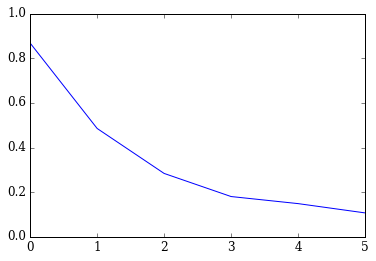

In [707]:
np.random.seed(35)
M = 100 # Number of objects
R = 500 # Number of relations
N = 3   # Number of dimensions
K = 6   # Number of generations
MF = hs_pfmean
#MF = hs_nemean

# Generate some random relations
rels = np.zeros(R, dtype=[('a', 'i4'), ('b', 'i4'), ('w', 'f4')])
rels['a'] = np.random.randint(0, M, R)
rels['b'] = np.random.randint(0, M, R)
#rels['w'] = np.abs(np.random.standard_normal(R))
rels['w'] = (np.random.exponential(1, R) + 1)
rels['w'] *= np.random.choice([-1,1], R) # Some negative

# rels['a'] = [2,3,1,1,2,3]
# rels['b'] = [1,2,3,4,4,4]
# rels['w'] = [1,1,1,-1,-1,-1]

# Run the algorithm
mus, deltas, vs = hs_relmap(rels, n=N, k=K, mf=MF, history=True)
nmus = mus / mus.max()
# Plot the amount of movement each generation.
pd.Series([hs_distance(vs[k],vs[k+1]).mean() for k in range(K)]).plot(ylim=(0.0,1))

# Current issues:
# * Bug? Including negative weights leads to wild swinging of many points each gen.
# * Design flaw? high R:M ratio and positive weights leads to all points clustering together

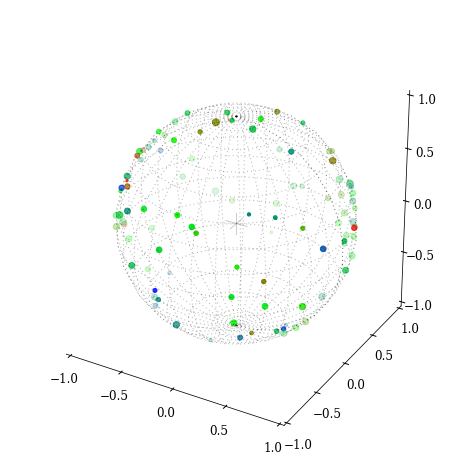

In [708]:
# Illustrate the incorrect results generated by a normalized
# weighted Euclidean mean.
STEPS = 10

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
drawsphere(ax1)
scat = ax1.scatter([], [], [], c=[])
def init():
    scat.set_offsets([])
    scat.set_3d_properties([],'z')
    scat.set_sizes([])
    scat.set_color([])
    return (scat,)
k, m, n = vs.shape
if n > 3: # Trim to the first three dimensions
    vs3 = hs_normalize(vs[:,:,:3].reshape((k*m,3))).reshape((k,m,3))
else:
    vs3 = vs
cs = np.zeros((m, 4)) # RGBA
# Indicate delta (charge) with color
cs[:,0] = deltas.clip(0,1)    # Red is positive
cs[:,1] = 1-np.abs(deltas)    # Green is neutral
cs[:,2] = (-deltas).clip(0,1) # Blue is negative
def animate(i):
    va = vs3[i/STEPS]
    vb = vs3[i/STEPS+1]
    t = i%STEPS / float(STEPS)
    t = t*t*(3 - 2*t) # Smoothstep
    v = hs_slerp(va, vb, t)
    # Fade points not facing the camera
    t, p = np.radians(90 - ax1.elev), np.radians(ax1.azim)
    atcam = np.array([sin(t) * cos(p), sin(t) * sin(p), cos(t)])
    ff = (v * atcam).sum(1) > 0 # Frontfacing?
    cs[:,3] = ff * 0.5 + 0.5
    scat.set_color([tuple(x) for x in cs])
    # Set the size based on the mass of the vector
    scat.set_sizes(nmus * 50)
    # Set the positions
    scat.set_offsets(v[:,:2])
    scat.set_3d_properties(v[:,2],'z')
    return (scat,)
aplot = anim.FuncAnimation(fig, animate, init_func=init,
                           frames=STEPS * K, interval=1000/STEPS, blit=True)
aplot

# Future Work (WIP)

* Is it possible to derive expected retention profiles analytically?
* Investigate why $iFEM$ exhibits such poor retention. Compounded precision errors? An implementation bug? $iFEM$ could be useful in certain application where associations are found incrementally over time.
* Why don't retention profiles match the simple *forgetting curve* formula? Why do they seem to converge on an asymptote greater than 0.5 similarity?

# Misc Possible References (WIP)

* https://en.wikipedia.org/wiki/Random_indexing
* [Geva, Shlomo & De Vries, Christopher M. (2011) TOPSIG : Topology Preserving Document Signatures. In Conference on Information and Knowledge Management 2011, 24-28 October 2011, Glasgow, Scotland.](http://eprints.qut.edu.au/43451/4/43451.pdf)
* [S. Li , 2011. Concise Formulas for the Area and Volume of a Hyperspherical Cap. Asian Journal of Mathematics & Statistics, 4: 66-70.](http://scialert.net/fulltext/?doi=ajms.2011.66.70&org=11)
* Related: [Sidiropoulos, Panagiotis. "N-sphere chord length distribution." arXiv preprint arXiv:1411.5639 (2014).
APA	](https://arxiv.org/pdf/1411.5639.pdf)
* [Item2Vec: Neural Item Embedding for Collaborative Filtering](https://arxiv.org/abs/1603.04259)
* [Salehian, Hesamoddin, et al. "An efficient recursive estimator of the Fréchet mean on a hypersphere with applications to medical image analysis." Mathematical Foundations of Computational Anatomy (2015).](https://www-sop.inria.fr/asclepios/events/MFCA15/Papers/MFCA15_4_2.pdf)
* [Shoemake, Ken. "Animating rotation with quaternion curves." ACM SIGGRAPH computer graphics. Vol. 19. No. 3. ACM, 1985.](http://run.usc.edu/cs520-s12/assign2/p245-shoemake.pdf)
* [Ebbinghaus, Hermann. Memory: A contribution to experimental psychology. No. 3. University Microfilms, 1913.](http://psychclassics.yorku.ca/Ebbinghaus/index.htm)
* [Goldberg, Ken, et al. "Eigentaste: A constant time collaborative filtering algorithm." Information Retrieval 4.2 (2001): 133-151.](http://www.ieor.berkeley.edu/~goldberg/pubs/eigentaste.pdf)
* [Buss, Samuel R., and Jay P. Fillmore. "Spherical averages and applications to spherical splines and interpolation." ACM Transactions on Graphics (TOG) 20.2 (2001): 95-126.
APA	](http://math.ucsd.edu/~sbuss/ResearchWeb/spheremean/paper.pdf)